In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import (KNeighborsRegressor, 
                               NearestNeighbors)
from sklearn.model_selection import (cross_val_score,
                                     train_test_split,
                                     TimeSeriesSplit)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Get data

In [2]:
def process_file(file_name):
    folder = os.getcwd()
    pip_decimal_places = {'EURUSD':4, 'USDJPY':2, 'NZDUSD':4, 'USDCAD':4, 'AUDUSD':4}
    raw = pd.read_csv(f"{folder}/{file_name}")
    raw[['Open','High','Low','Close']] = raw[['Open','High','Low','Close']] * 10**pip_decimal_places[file_name[:6]]
    time_col = list(raw.columns)[0]
    raw.rename(columns={time_col:'Gmt time'}, inplace=True)
    return raw

# file = 'EURUSD_1h_2003-2010.csv'
# data = process_file(file)
# data

In [3]:
def get_data(files, plot=False):
    folder = os.getcwd()
    all_data = []
    for file in files:
        print(file)
        raw = process_file(file)
        time_col = list(raw.columns)[0]
        raw['time'] = pd.to_datetime(raw[time_col].str[:16], dayfirst=True)
        raw.drop(time_col,inplace=True, axis=1)
        raw['time'] = raw['time'].astype(np.int64) // 10 ** 9
        raw.drop('Volume', axis=1, inplace=True)
        raw['instrument'] = file[:6]
        if plot == True:
            raw['close'].plot()
        raw = raw[['time','instrument','Open','High','Low','Close']]
        data = raw.to_numpy()
        all_data.append(data)
    return all_data

files = ['EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv']
data = get_data(files)
data

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv


[array([[1052082000, 'EURUSD', 11228.400000000001, 11233.799999999997,
         11224.199999999999, 11230.500000000002],
        [1052085600, 'EURUSD', 11227.400000000001, 11230.2, 11222.6,
         11224.100000000002],
        [1052089200, 'EURUSD', 11223.5, 11223.5, 11216.0,
         11216.899999999998],
        ...,
        [1262372400, 'EURUSD', 14333.499999999998, 14335.3, 14331.5,
         14334.2],
        [1262376000, 'EURUSD', 14333.1, 14335.3, 14331.6, 14335.2],
        [1262379600, 'EURUSD', 14333.3, 14335.599999999999, 14331.5,
         14333.499999999998]], dtype=object),
 array([[1272837600, 'EURUSD', 13297.4, 13358.6, 13297.4,
         13330.799999999997],
        [1272841200, 'EURUSD', 13330.5, 13330.5, 13310.1,
         13318.000000000002],
        [1272844800, 'EURUSD', 13318.2, 13325.8, 13308.4, 13311.2],
        ...,
        [1579892400, 'EURUSD', 11027.9, 11032.9, 11027.4,
         11029.599999999999],
        [1579896000, 'EURUSD', 11029.500000000002, 11030.1, 110

## Fit data for KNN

In [4]:
def fit_data_for_knn(all_data, window=20, n_candles=[1], close_only=False):
    final_knn_data = []
    for data in all_data: # loop through each instruments data
        knn_data = []
        for idx in range(len(data) - window - max(n_candles)):
            time_col = data[idx, 0]
            inst_col = data[idx, 1]
            if close_only:
                rows = data[idx:idx + window, -1] # only keep close column (the last column)
                # Normalise candles to 100 start (easy to calculate percentages later) (need to do more research)
                rows = (rows / rows[0]) * 100
            else:
                rows = data[idx:idx + window, 2:] # skip time and inst cols
                # Normalise candles to 100 start (easy to calculate percentages later) (need to do more research)
                rows = (rows / rows[0,0]) * 100

            ####
            next_candle = data[idx + window + 1, 2:]
            final_row = rows.flatten()
            for c in n_candles:
                next_n_candle = data[idx + window + c, 2:]
                open_close_dist = ((next_n_candle[3] / next_candle[0]) - 1) * 100
                open_close_dist = open_close_dist / c**0.5
                final_row = np.append(final_row, open_close_dist)
            final_row = np.append(inst_col, final_row)
            final_row = np.append(time_col, final_row)
            knn_data.append(final_row)
        knn_data = pd.DataFrame(knn_data)
        target_cols = list(knn_data.columns)[-len(n_candles):]
        target_names = [f"target_bars_{c}" for c in n_candles]
        target_dict = dict(zip(target_cols, target_names))
        knn_data.rename(target_dict, axis='columns',inplace=True)
        final_knn_data.append(knn_data)
    final_knn = pd.concat(final_knn_data, axis=0)
    final_knn.sort_values(0, inplace=True)
    final_knn.reset_index(inplace=True, drop=True)
    final_knn.drop(0, axis=1, inplace=True)
    final_knn.drop(1, axis=1, inplace=True)
    print('fitted knn data')
    return final_knn

# knn_data = fit_data_for_knn(data, window=10, n_candles=[1,2,3,4,5,6,7,8,9], close_only=True)
# knn_data.head()

## PCA

In [5]:
def find_n_idx_components(pca_obj, variance_thresh=0.99):
    explained_var = pca_obj.explained_variance_ratio_
    for idx in range(len(explained_var)):
        var_list = explained_var[:idx]
        if sum(var_list) >= variance_thresh:
#             print(idx + 1, 'pca features equals',sum(var_list),'explained variance')
#             print('this reduces dimensions down from', len(explained_var), 'to', idx + 1)
            return idx
        
# n_pc = find_n_idx_components(pca, variance_thresh=0.99)
# n_pc


def scale_data(X_train, X_test, df=False):
    scaler = StandardScaler()
    x_train_scale = scaler.fit_transform(X_train)
    mean, variance = scaler.mean_, scaler.var_
    x_test_scale = scaler.transform(X_test)
    if df:
        return pd.DataFrame(x_train_scale), pd.DataFrame(x_test_scale)
    return x_train_scale, x_test_scale


def pca_cv(x_train_cv, x_test_cv):  
    x_train_cv_scale, x_test_cv_scale = scale_data(x_train_cv, x_test_cv)
    pca = PCA()
    pcas = pca.fit_transform(x_train_cv_scale)
    n_pc_idx = find_n_idx_components(pca, variance_thresh=0.98)
    X_train_cv_pca = pd.DataFrame(pcas[:,:n_pc_idx])
    eigens = pca.components_[:n_pc_idx,:]
    X_test_cv_pca = x_test_cv_scale @ eigens.T
    
    return pd.DataFrame(X_train_cv_pca), pd.DataFrame(X_test_cv_pca)
    
# x_train_cv, x_test_cv =  X_train.iloc[0:100, :], X_train.iloc[100:110, :] 
# X_train_cv_pca, X_test_cv_pca = pca_cv(x_train_cv, x_test_cv)
# X_train_cv_pca

## KNN train

In [6]:
def trading_scorer(estimator, X, y):
    pred = estimator.predict(X)
    target_col = list(y.columns)[0]
    # Caclulate profit
    pred = pd.Series(pred.flatten(), name='pred')
    i_data = pd.concat([pred, y.reset_index(drop=True)],axis=1)
    i_data['pred_dir'] = i_data['pred'].map(lambda x: 1 if x > 0 else -1)
    i_data['profit'] = i_data[target_col] * i_data['pred_dir']
    i_data['run_profit'] = i_data['profit'].cumsum()
    romad = i_data['run_profit'].values[-1] / ((i_data['run_profit'] - i_data['run_profit'].cummax()).min()*-1)
    return romad

def cuda_trading_scorer(pred, y, output_candles, return_df=False):
    # Caclulate profit
    pred = pd.Series(pred, name='pred')
    i_data = pd.concat([pred, y.reset_index(drop=True)], axis=1) 
    i_data['pred_dir'] = i_data['pred'].map(lambda x: 1 if x > 0 else -1)
    candle_romads = {}
    for c in output_candles:
        target_col = f'target_bars_{c}'
        i_data['profit'] = i_data[target_col] * i_data['pred_dir']
        i_data['run_profit'] = i_data['profit'].cumsum()
        romad = i_data['run_profit'].values[-1] / ((i_data['run_profit'] - i_data['run_profit'].cummax()).min()*-1)
        candle_romads[c] = romad
    if return_df == True:
        return candle_romads, i_data
    return candle_romads


# def cuda_trading_scorer_vote(pred_mean, pred_median, y, vote_type, target_col='target', return_df=False):
#     # Caclulate profit
#     pred_mean = pd.Series(pred_mean, name='pred_mean')
#     pred_median = pd.Series(pred_median, name='pred_median')
#     i_data = pd.concat([pred_mean, pred_median, y.reset_index(drop=True)], axis=1)
    
#     def vote(row):
#         if (row['pred_mean'] > 0) and (row['pred_median'] > 0):
#             return (row['pred_mean'] + row['pred_median']) / 2
#         elif (row['pred_mean'] < 0) and (row['pred_median'] < 0):
#             return (row['pred_mean'] + row['pred_median']) / 2
#         else:
#             return 0  
        
#     def vote_sum(row):
#         return (row['pred_mean'] + row['pred_median']) / 2
    
#     if vote_type == 'vote':
#         scorer = vote 
#     elif vote_type == 'vote_sum':
#         scorer = vote_sum
#     else:
#         raise Exception('Vote_type not recognised')
        
#     i_data['pred'] = i_data.apply(scorer, axis=1)
#     i_data['pred_dir'] = i_data['pred'].map(lambda x: 1 if x > 0 else -1)
#     i_data['profit'] = i_data[target_col] * i_data['pred_dir']
#     i_data['run_profit'] = i_data['profit'].cumsum()
#     romad = i_data['run_profit'].values[-1] / ((i_data['run_profit'] - i_data['run_profit'].cummax()).min()*-1)
#     if return_df == True:
#         return romad, i_data
#     return romad


def cuda_trading_scorer_vote(dict_of_results, y, output_candles, threshold=0.5, return_df=False):
    # Caclulate profit
    results = pd.DataFrame(dict_of_results).T
    
    results = results.applymap(lambda x: 1 if x > 0 else -1)
    num_scorers = len(results.columns)
    results['ratio'] = ((results.sum(axis=1)/2) + ((num_scorers/2) * results.median(axis=1))) / num_scorers
    results['ratio'] = results['ratio'].map(lambda x: 0.5 if x == 0 else x)
    
    def vote(x):
        if x >= threshold: return 1
        elif x <= -threshold: return -1
        else: return 0
        
    results['pred_dir'] = results['ratio'].map(vote)
    i_data = pd.concat([results, y.reset_index(drop=True)], axis=1) 
    candle_romads = {}
    for c in output_candles:
        target_col = f'target_bars_{c}'
        i_data['profit'] = i_data[target_col] * i_data['pred_dir']
        i_data['run_profit'] = i_data['profit'].cumsum()
        romad = i_data['run_profit'].values[-1] / ((i_data['run_profit'] - i_data['run_profit'].cummax()).min()*-1)
        candle_romads[c] = romad
    if return_df == True:
        return candle_romads, i_data
    return candle_romads

## GPU

In [7]:
import torch
print(torch.cuda.get_device_name(device=None), torch.cuda.is_available())

def knn_cuda(X_train, X_test, n_neighbors=5, gpu_step_size=500):

    X_train_torch = torch.from_numpy(X_train.to_numpy()).cuda()
    X_test_torch = torch.from_numpy(X_test.to_numpy()).cuda()

    test_size = X_test.shape[0]
    start = 0
    n_neighbor_indices = []
    while start <= test_size:
        dist = torch.cdist(X_train_torch, X_test_torch[start:start + gpu_step_size])
        knn = dist.T.topk(n_neighbors, largest=False)
        n_neighbor_indices.append(knn.indices.cpu().numpy())
        start += gpu_step_size

    all_indices = np.vstack(n_neighbor_indices)

#     del X_train_torch
#     del X_test_torch
#     del dist
#     del knn
    torch.cuda.empty_cache() 

    return all_indices

# all_files = ['EURUSD_1h_2003-2010.csv']
# data = get_data(all_files)
# knn_data = fit_data_for_knn(data, window=5, n_candles=[1])
# target = 'target_bars_1'
# features = [col for col in knn_data.columns if col != target]
# X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]], test_size=0.3, shuffle=False)

# all_indices = knn_cuda(X_train, X_test, n_neighbors=5, gpu_step_size=500)
# all_indices

GeForce RTX 2070 True


In [8]:
import torch
print(torch.cuda.get_device_name(device=None), torch.cuda.is_available())

def knn_cuda_batch(X_train, X_test, max_neighbors=10, windows=[20], gpu_step_size=500, close_only=False):

    bars = 1 if close_only else 4
    X_train_torch = torch.from_numpy(X_train.to_numpy()).cuda()
    X_test_torch = torch.from_numpy(X_test.to_numpy()).cuda()

    test_size = X_test.shape[0]
    window_indices = {}
    for w in windows:
        n_neighbor_indices = []
        start = 0
        while start <= test_size:
            # sorted smallest first
            dist = torch.cdist(X_train_torch[:, -w*bars:], X_test_torch[start:start + gpu_step_size, -w*bars:])
            knn = dist.T.topk(max_neighbors, largest=False, sorted=True)
            n_neighbor_indices.append(knn.indices.cpu().numpy())
            start += gpu_step_size
        all_indices = np.vstack(n_neighbor_indices)
        window_indices[w] = all_indices

#     del X_train_torch
#     del X_test_torch
#     del dist
#     del knn
    torch.cuda.empty_cache() 

    return window_indices   

# all_files = ['EURUSD_1h_2003-2010.csv']
# data = get_data(all_files)
# knn_data = fit_data_for_knn(data, window=30, n_candles=[1])
# target = 'target_bars_1'
# features = [col for col in knn_data.columns if col != target]
# X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]], test_size=0.3, shuffle=False)

# window_indices = knn_cuda_batch(X_train, X_test, max_neighbors=10, windows=[10, 20,30], gpu_step_size=500)
# window_indices

GeForce RTX 2070 True


In [9]:
def TimeSeriesShift(n_splits, X_train):
    split_size = (len(X_train) // (n_splits + 1)) + n_splits
    start = 0
    while start < (len(X_train) - split_size): # gives wiggle room for non accurate split size, but stops ~ 2* split size
        train_end = start + split_size
        test_end = min(start + split_size*2, len(X_train)) # stops indexes from getting too large
        x_train_split = np.array(range(start, train_end))
        x_test_split = np.array(range(train_end, test_end))
        yield (x_train_split, x_test_split)
        start += split_size
        

def time_series_cv_knn_batch(X_train, y_train, n_splits=3, n_neighbors=[10], windows=[20],
                             output_candles=list(range(1,31)), gpu_step_size=500,
                             ensemble=False, threshold=0.5, scale_only=False, pca=False, shift_cv=False, close_only=False):
    '''
    ensemble = False, 'vote', 'mean', 'median'
    '''
    print('ensemble type:', ensemble)
    
    if shift_cv:
        print('shift cv')
        splits_gen = TimeSeriesShift(n_splits, X_train)
    else:
        print('split cv')
        splits_gen = TimeSeriesSplit(n_splits=n_splits).split(X_train)

        
    cv_score = {'mean':{},'median':{},'ensemble':[]}
    for train_idx, test_idx in splits_gen:
        x_train_cv, x_test_cv =  X_train.iloc[train_idx, :], X_train.iloc[test_idx, :] 
        if pca:
            x_train_cv, x_test_cv = pca_cv(x_train_cv, x_test_cv)
        elif scale_only:
            print('scaling')
            x_train_cv, x_test_cv = scale_data(x_train_cv, x_test_cv, df=True)
            
        window_indices = knn_cuda_batch(x_train_cv, x_test_cv, max_neighbors=max(n_neighbors), windows=windows,
                                        gpu_step_size=gpu_step_size, close_only=close_only)
        y_train_numpy = y_train.to_numpy()
        pred_ensemble = []
        for w in windows:
            for c_idx, c in enumerate(output_candles):
                cv_score['mean'].setdefault((w, c), {})
                cv_score['median'].setdefault((w, c), {})
                for n in n_neighbors:
                    pred_mean = [np.mean(y_train_numpy[indices, c_idx]) for indices in window_indices[w][:,:n]]
                    if ensemble:
                        #print('window:',w,'output_candles:',c,'neighbors:',n)
                        pred_ensemble.append(pred_mean)
                    else:
                        pred_median = [np.median(y_train_numpy[indices, c_idx]) for indices in window_indices[w][:,:n]]
                        score_mean = cuda_trading_scorer(pred_mean, y_train.iloc[test_idx, :], output_candles=[c])
                        score_median = cuda_trading_scorer(pred_median, y_train.iloc[test_idx, :], output_candles=[c])
                        cv_score['mean'][(w, c)].setdefault(n, []).append(score_mean[c])
                        cv_score['median'][(w, c)].setdefault(n, []).append(score_median[c])
                        #print('window:',w,'output_candles:',c,'neighbors:',n, 'score med:',score_median,'score mean:',score_mean)

        
        if ensemble:
            if ensemble == 'vote':
                score_mean = cuda_trading_scorer_vote(pred_ensemble, y_train.iloc[test_idx, :],
                             output_candles=output_candles, threshold=threshold)
            else:
                results_scorer = np.mean if ensemble == 'mean' else np.median
                score_mean = cuda_trading_scorer(results_scorer(pred_ensemble, axis=0), y_train.iloc[test_idx, :],
                             output_candles=output_candles)
            cv_score['ensemble'].append(score_mean)
                                         
        print('CV done...')
    
    if ensemble:
        ensemble_data = {}
        for cv in cv_score['ensemble']:
            for candle, score in cv.items():
                ensemble_data.setdefault(candle,[]).append(score)
        return {'ensemble':ensemble_data}
    else:
        return {'mean':cv_score['mean'], 'median':cv_score['median']}

In [10]:
def time_series_cv_knn_vote(X_train, y_train, n_splits=3, n_neighbors=10, gpu_step_size=500, vote_type='vote_sum',
                            scale_only=False, pca=False):

    tss = TimeSeriesSplit(n_splits=n_splits)
    splits_gen = tss.split(X_train)

    cv_score = []
    for train_idx, test_idx in splits_gen:
        x_train_cv, x_test_cv =  X_train.iloc[train_idx, :], X_train.iloc[test_idx, :] 
        if pca:
            x_train_cv, x_test_cv = pca_cv(x_train_cv, x_test_cv)
        elif scale_only:
            print('scaling')
            x_train_cv, x_test_cv = scale_data(x_train_cv, x_test_cv, df=True)
        all_indices = knn_cuda(x_train_cv, x_test_cv, n_neighbors=n_neighbors, gpu_step_size=gpu_step_size)
        y_train_numpy = y_train.to_numpy()
        pred_mean = [np.mean(y_train_numpy[indices]) for indices in all_indices]
        pred_median = [np.median(y_train_numpy[indices]) for indices in all_indices]
        score = cuda_trading_scorer_vote(pred_mean, pred_median, y_train.iloc[test_idx, :], vote_type=vote_type)
        cv_score.append(score)
    
    return np.array(cv_score)

## Test GPU model vs Sklearn output

In [11]:
def test_gpu_vs_sklearn():
    
    all_files = ['EURUSD_1h_2003-2010.csv']
    data = get_data(all_files)

    window = 5
    candles = 1
    n_neighbors = 5

    knn_data = fit_data_for_knn(data, window=window, n_candles=[candles])

    target = 'target_bars_1'
    features = [col for col in knn_data.columns if col != target]

    X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]], test_size=0.3, shuffle=False)

    window_indices = knn_cuda_batch(X_train, X_test, max_neighbors=n_neighbors, windows=[window],
                                    gpu_step_size=gpu_step_size)
    cuda_indices = window_indices[window]

    model = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1, algorithm='brute')
    model.fit(X_train)
    sklearn_indices = model.kneighbors(X_test)[1]

    print('sklearn:',sklearn_indices)
    print('cuda:   ',cuda_indices)
    print('equal:', (sklearn_indices != cuda_indices).sum() == 0)

# test_gpu_vs_sklearn()

In [12]:
def test_gpu_vs_sklearn_time_series():
   
    all_files = ['EURUSD_1h_2003-2010.csv']
    data = get_data(all_files)
    
    n_splits = 5
    window = 5
    candles = 2
    n_neighbors = 5

    knn_data = fit_data_for_knn(data, window=window, n_candles=[candles])

    target = f'target_bars_{candles}'
    features = [col for col in knn_data.columns if col != target]

    X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]], test_size=0.3, shuffle=False)

    #### cuda #####
    
    cv_score_cuda = time_series_cv_knn_batch(X_train, y_train, n_splits=n_splits, n_neighbors=[n_neighbors], windows=[window],
                                             output_candles=[candles], gpu_step_size=500)
    cv_score_cuda = cv_score_cuda['mean'][(window, candles)][n_neighbors]

    ##### sklearn #####
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    n_splits = n_splits
    tss = TimeSeriesSplit(n_splits=n_splits)
    cv_score = cross_val_score(model, X_train, y_train, cv=tss, scoring=trading_scorer)

    print('sklearn:',list(cv_score))
    print('cuda:   ',cv_score_cuda)
    print('equal:', list(cv_score) == cv_score_cuda)

# test_gpu_vs_sklearn_time_series()

### Visualization of knn bars

In [43]:
def plot_bars(data, window):
    numpy_bars = data.to_numpy().reshape(-1,4)
    times = pd.date_range(start=datetime.now(), periods=window)
    bars = pd.DataFrame(numpy_bars, columns=['Open','High','Low','Close'])
    bars['time'] = times
    bars = bars[['time','Open','High','Low','Close']]
    bars.set_index('time',drop=True, inplace=True)
    mpf.plot(bars, type='candle', figscale=0.9)
    
def plot_n_predictions(X_test, y_test, X_train, y_train, window, predictions, prediction_idx, n_charts_to_plot):
    print('----- main ------')
    print(y_test.iloc[prediction_idx])
    plot_bars(X_test.iloc[prediction_idx], window)
    print('----- prediction values ------')
    preds = y_train.iloc[predictions[prediction_idx]]
    print(preds.describe())
    print('median:',preds.median().values)
    print()
    print('----- plotting of neighbors -----')
    for b in predictions[prediction_idx][:n_charts_to_plot]:
        bars = X_train.iloc[b]
        target = y_train.iloc[b]
        print(target)
        plot_bars(bars, window)

In [16]:
instrument = ['EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv']
data = get_data(instrument)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv


In [44]:
window = 30
n_candles = [1] # how many canldes to predict
knn_data = fit_data_for_knn(data, window=window, n_candles=n_candles)

target =  [f"target_bars_{c}" for c in n_candles]
features = [col for col in knn_data.columns if col not in target]

X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[target], test_size=0.3, shuffle=False)
#X_train, X_test = scale_data(X_train, X_test, df=True)

knn = NearestNeighbors(n_neighbors=10)
knn.fit(X_train, y_train)
dist, neighbors = knn.kneighbors(X_test)

KeyboardInterrupt: 

----- main ------
target_bars_1   -0.089632
Name: 71677, dtype: float64


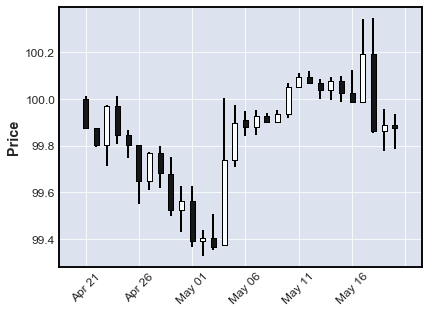

----- prediction values ------
       target_bars_1
count      10.000000
mean        0.024062
std         0.060422
min        -0.085192
25%         0.005800
50%         0.025915
75%         0.052646
max         0.117528
median: [0.02591456]

----- plotting of neighbors -----
target_bars_1    0.004147
Name: 7844, dtype: float64


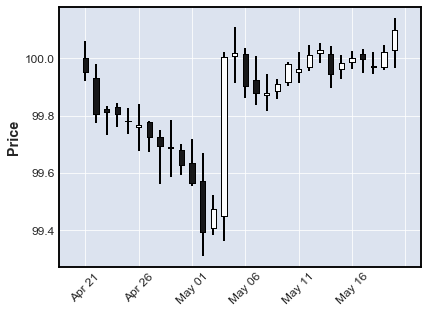

target_bars_1    0.023874
Name: 41206, dtype: float64


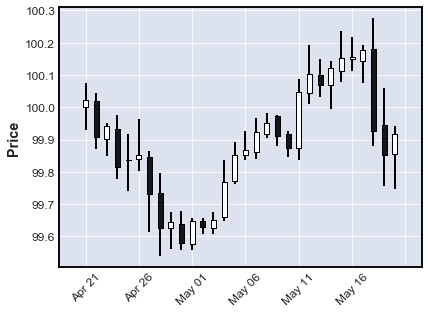

target_bars_1    0.0484
Name: 41207, dtype: float64


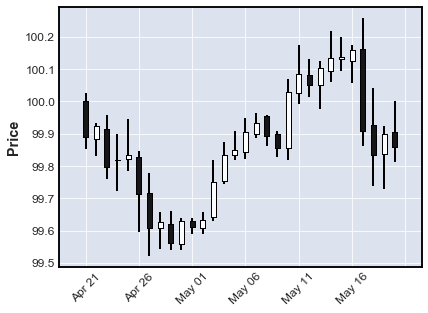

target_bars_1   -0.085192
Name: 52758, dtype: float64


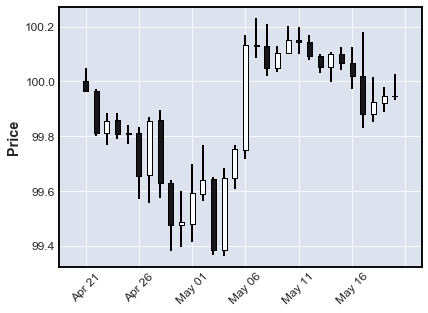

target_bars_1    0.090478
Name: 33166, dtype: float64


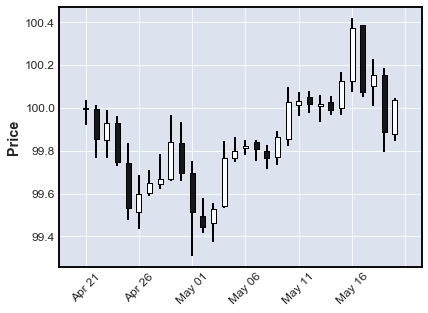

In [48]:
import mplfinance as mpf
plot_n_predictions(X_test, y_test, X_train, y_train, window, neighbors, prediction_idx=0, n_charts_to_plot=5)

#### end

## Cross fold validation

In [43]:
all_files = [
             'EURUSD_1h_2003-2010.csv',# 'EURUSD_1h_2010-2020.csv',
#              'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
#              'NZDUSD_1h_2003-2020.csv',
#              'AUDUSD_1h_2003-2020.csv',
#              'USDCAD_1h_2003-2020.csv',
            ]
data = get_data(all_files)

EURUSD_1h_2003-2010.csv


In [66]:
gpu_step_size = 250
n_splits = 10

windows = [10,20,30,40,50]
output_candles = list(range(1,16,1)) + list(range(16,30,2))
n_neighbors = [5,10,25,100,200,500,1000,2000]
close_only=True

ensemble = False #False, 'vote', 'median', 'mean'
threshold = 0.5 # only used if ensemble == 'vote'
### ^ shoud add threshold var to scorer func to iterate through it and produce tables, rather than waste time putting singles

scale_only = False
pca = False
shift_cv = False

start = datetime.now()

knn_data = fit_data_for_knn(data, window=max(windows), n_candles=output_candles, close_only=close_only)

target =  [f"target_bars_{c}" for c in output_candles]
features = [col for col in knn_data.columns if col not in target]

# X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]],
#                                                     test_size=0.3, shuffle=False)
X_train = knn_data[features]
y_train = knn_data[target]

cv_score_cuda = time_series_cv_knn_batch(X_train, y_train, n_splits=n_splits, n_neighbors=n_neighbors,
                                        windows=windows, output_candles=output_candles,
                                        gpu_step_size=gpu_step_size,
                                        ensemble=ensemble, threshold=threshold,
                                        scale_only=scale_only, pca=pca, shift_cv=shift_cv, close_only=close_only)

inspect_results = pd.DataFrame(cv_score_cuda)
inspect_results.to_pickle(f'inspect_results_backup.pkl')
#del knn_data, X_train, y_train #X_train, X_test, y_train, y_test
        
end = datetime.now()
print('it took:',end-start)
all_results = inspect_results.copy()
inspect_results

fitted knn data
ensemble type: False
split cv
CV done...
CV done...
CV done...
CV done...
CV done...
CV done...
CV done...
CV done...
CV done...
CV done...
it took: 0:30:44.392398


mean  \
10 1   {5: [0.9352295567858827, -0.6066574526507791, ...   
   2   {5: [5.432429464170798, 0.014771754302762707, ...   
   3   {5: [3.5825885019644574, 4.3239238082629505, 0...   
   4   {5: [2.5684861413757307, 3.233830197868283, -0...   
   5   {5: [4.242418938455392, 2.8996311022527115, -0...   
...                                                  ...   
50 20  {5: [-0.6417485761339152, 0.17372149698685946,...   
   22  {5: [-0.7344157736474435, 0.8201201270994368, ...   
   24  {5: [-0.7169925529093573, 1.3474775441195583, ...   
   26  {5: [-0.7464330597738168, 0.6153858366982167, ...   
   28  {5: [-0.7590898916161094, 0.6204772690631435, ...   

                                                  median  
10 1   {5: [-0.21977508964376077, -0.5022176851336504...  
   2   {5: [7.830676368029783, -0.3127413566806833, 1...  
   3   {5: [3.980305411982339, 1.7177444091063963, 1....  
   4   {5: [0.45047493884532186, 1.886304972140783, -...  
   5   {5: [0.8064655737421051, 1.4082664385677537, 0...  
...                                                  ...  
50 20  {5: [-0.4895665223255277, 0.18619466601581455,...  
   22  {5: [-0.21728640127452084, 0.04514978330150224...  
   24  {5: [-0.3661361319842553, 0.2516526077560874, ...  
   26  {5: [-0.3317754943396373, 0.4321938112171373, ...  
   28  {5: [-0.20052827802344364, 0.9550811082205687,...  

[110 rows x 2 columns]

In [214]:
# gpu_step_size = 200

# start = datetime.now()
# all_results = {'vote':{}}
# for window in [40]:
#     for n_candles in [5]:
#         knn_data = fit_data_for_knn(data, window=window, n_candles=n_candles)
#         target = 'target'
#         features = [col for col in knn_data.columns if col != target]
        
# #         X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[[target]],
# #                                                             test_size=0.3, shuffle=False)
#         X_train = knn_data[features]
#         y_train = knn_data[[target]]
        
#         results = {'vote':{}}
#         for n in [500]:
#             cv_score_cuda = time_series_cv_knn_vote(X_train, y_train, n_splits=10, n_neighbors=n, gpu_step_size=gpu_step_size, 
#                                                     vote_type='vote_sum', scale_only=False, pca=False)

#             results['vote'][n] = cv_score_cuda
#             print('window',window,'n_candles',n_candles,'nn',n)
#             print('cv_score_vote',cv_score_cuda)
#             print('----------')

#         all_results['vote'][(window, n_candles)] = results['vote']
#         print('results', results)
#         inspect_results = pd.DataFrame(all_results)
#         inspect_results.to_pickle(f'inspect_results_backup.pkl')
#         del knn_data, X_train, y_train #X_train, X_test, y_train, y_test
        
# end = datetime.now()
# print('it took:',end-start)
# all_results

In [67]:
inspect_results = pd.DataFrame(all_results)
now = str(datetime.now().date())
inspect_results.to_pickle(f'inspect_results_{now}.pkl')
new_data = pd.read_pickle(f'inspect_results_{now}.pkl')
means = pd.DataFrame(new_data['mean'].to_dict())
medians = pd.DataFrame(new_data['median'].to_dict())
medians

10  \
                                                     1    
5     [-0.21977508964376077, -0.5022176851336504, 0....   
10    [1.633920297059753, 0.09857635221837377, 0.143...   
25    [3.702683309081937, -0.4899688594962659, 1.262...   
100   [-0.5760557703052352, 0.8612261468222591, 0.43...   
200   [-0.49196908103879194, 2.138841257036725, 0.10...   
500   [-0.703516450387441, 0.2837954331120481, -0.41...   
1000  [-0.7945917359942425, -0.5345111364777277, -0....   
2000  [-0.8619319698956328, 5.064265334415392, -0.43...   

                                                         \
                                                     2    
5     [7.830676368029783, -0.3127413566806833, 1.720...   
10    [2.3079173186590407, -0.34458325402600665, 1.1...   
25    [0.6905956831922422, -0.25804837632109245, 3.6...   
100   [-0.49843124436827546, 0.6322220287126953, 2.8...   
200   [-0.2293065174130116, 1.4454479239385736, 2.66...   
500   [-0.7803413114567185, -0.44851092598704556, -0...   
1000  [-0.7493174098840479, 1.461311683166403, -0.65...   
2000  [-0.5076934222752866, 2.413111436145993, -0.56...   

                                                         \
                                                     3    
5     [3.980305411982339, 1.7177444091063963, 1.0080...   
10    [1.1820847575277489, 1.1341668061158787, 2.930...   
25    [0.27697417576055117, 0.8099422050216297, 2.12...   
100   [-0.6819602910005464, 2.2078730525797954, 2.44...   
200   [-0.07349860930603365, 1.0871710419804894, 0.3...   
500   [-0.8414928215776848, 0.30301628041210404, 0.7...   
1000  [-0.6539482971324118, 0.33526862968863574, -0....   
2000  [-0.730169034464632, -0.45813219839304226, -0....   

                                                         \
                                                     4    
5     [0.45047493884532186, 1.886304972140783, -0.18...   
10    [1.5610421929289013, 3.162446024969406, 1.3074...   
25    [-0.21213432173464158, 1.4698132387005718, 1.2...   
100   [-0.5303565862823522, 1.5484700437528658, 1.08...   
200   [-0.3523859449933858, 1.0227025454870002, 0.13...   
500   [-0.8051852939292754, 0.3316740208366806, -0.3...   
1000  [-0.6034131934387708, 0.18059886134916803, -0....   
2000  [-0.9277816382410043, -0.7285861658591722, -0....   

                                                         \
                                                     5    
5     [0.8064655737421051, 1.4082664385677537, 0.717...   
10    [1.9230932704308294, 1.6013082309249567, 2.527...   
25    [-0.3770427794433835, 2.170855417101929, 2.956...   
100   [-0.704122118988285, 1.202278498125144, 1.4845...   
200   [-0.7058672467515665, 0.8218454286677938, -0.0...   
500   [-0.7906062157313664, -0.21892115305830792, -0...   
1000  [-0.7825387055449637, -0.15891533324810245, -0...   
2000  [-0.9363044671707569, -0.7386257311933437, -0....   

                                                         \
                                                     6    
5     [1.693521166611848, -0.20303590585469394, 1.75...   
10    [0.4188914491732573, 2.9687733075360883, 1.453...   
25    [-0.31641869816584367, -0.0906270782078394, 3....   
100   [-0.31345633681660445, 2.36676452232864, 0.641...   
200   [-0.6379164871157571, 3.6212658903315584, -0.3...   
500   [-0.7445646133553845, -0.36635363652454067, -0...   
1000  [-0.8437243464153639, -0.053010899699393654, -...   
2000  [-0.9255282834106392, -0.815546145715746, -0.9...   

                                                         \
                                                     7    
5     [2.6028989450108813, 0.42446574393380104, 0.19...   
10    [3.2132176214198265, 1.0210917628444958, -0.14...   
25    [0.7520410999994643, 0.9095596359279502, 1.987...   
100   [-0.14382876854498114, 0.32932858542427995, 0....   
200   [-0.5679063349528414, 0.535237285291979, -0.09...   
500   [-0.7413581475907782, 0.07625308085302444, -0....   
1000  [-0.8375487122151134, -0.6245

In [21]:
# bars = 2
# cvs = [round(d,2) for d in new_data['ensemble'][bars]]
# print(cvs)
# print(sum(cvs))
# pd.Series(new_data['ensemble'][bars]).plot(lw='4', title=f'ensemble {bars} bars')

In [68]:
scorers = ['mean','median'] # ['vote'] ['mean','median'] ['ensemble']
tables = {s:{} for s in scorers}
for scorer in scorers:
    if scorer == 'ensemble':
        the_data = new_data.copy()
    else:
        the_data = pd.DataFrame(new_data[scorer].to_dict())
    the_data = the_data.applymap(lambda x: np.array(x))
    tables[scorer]['learning'] = the_data.applymap(lambda x: int(x[int(n_splits*0.25)] < x[n_splits // 2] < x[int(n_splits*0.75)]))
    tables[scorer]['sum'] = the_data.applymap(lambda x: np.sum(x))
    tables[scorer]['sum_std'] = the_data.applymap(lambda x: np.sum(x) / np.std(x))
    tables[scorer]['median'] = the_data.applymap(lambda x: np.median(x))
    tables[scorer]['min'] = the_data.applymap(lambda x: np.min(x))
    tables[scorer]['last'] = the_data.applymap(lambda x: x[-1])
    weight_arr = list(range(n_splits))
    tables[scorer]['weighted'] = the_data.applymap(lambda x: ((np.array(x) * weight_arr) / sum(weight_arr)).sum())

----------------------


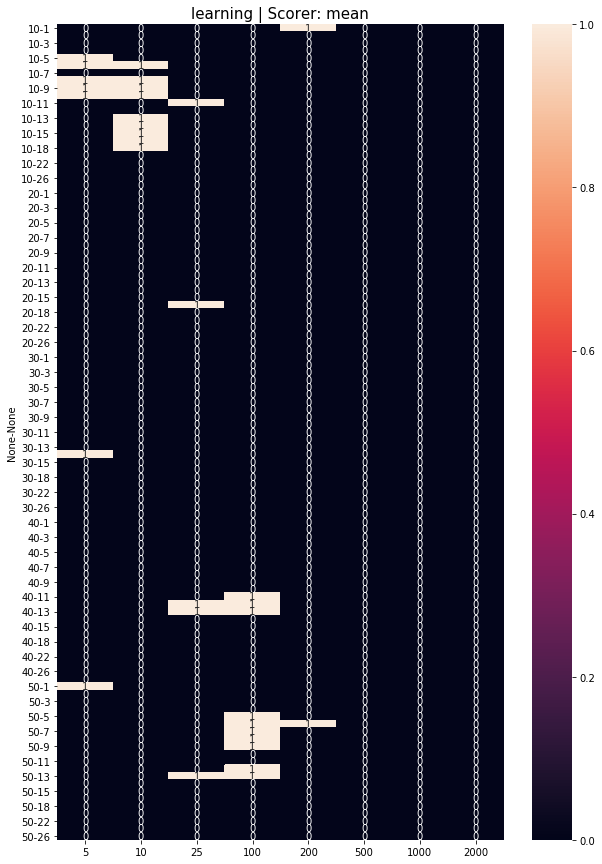

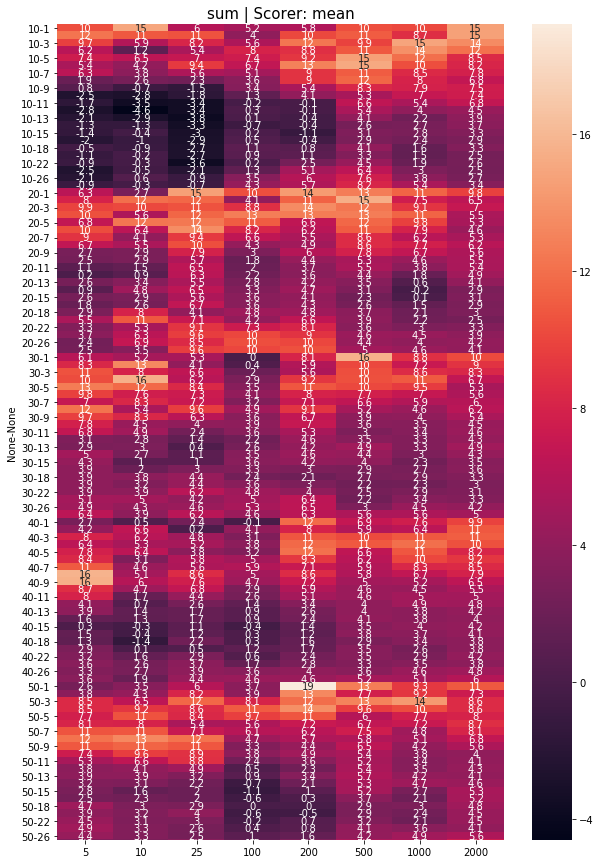

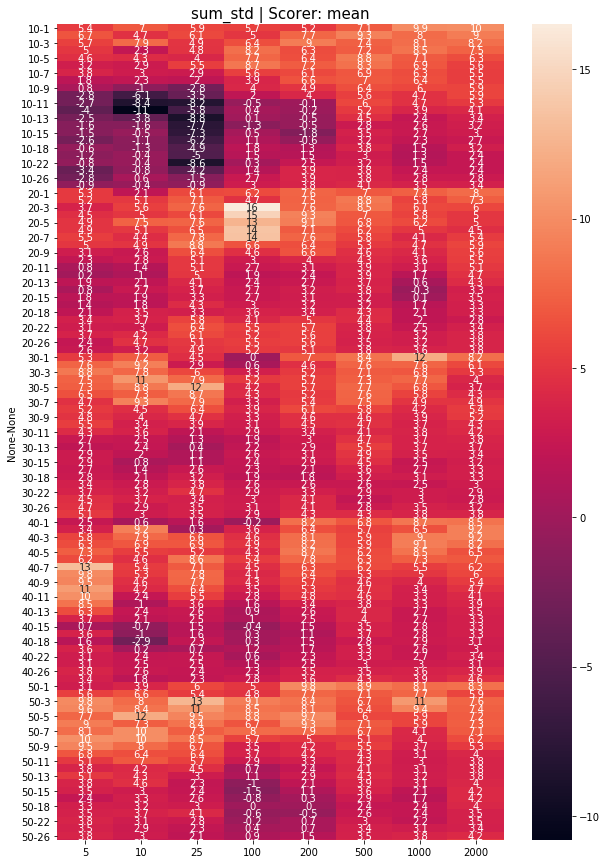

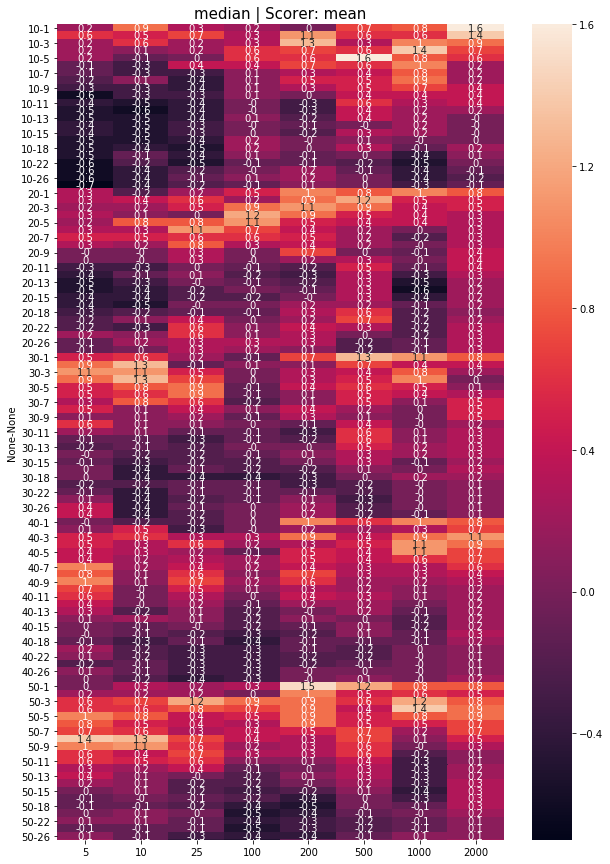

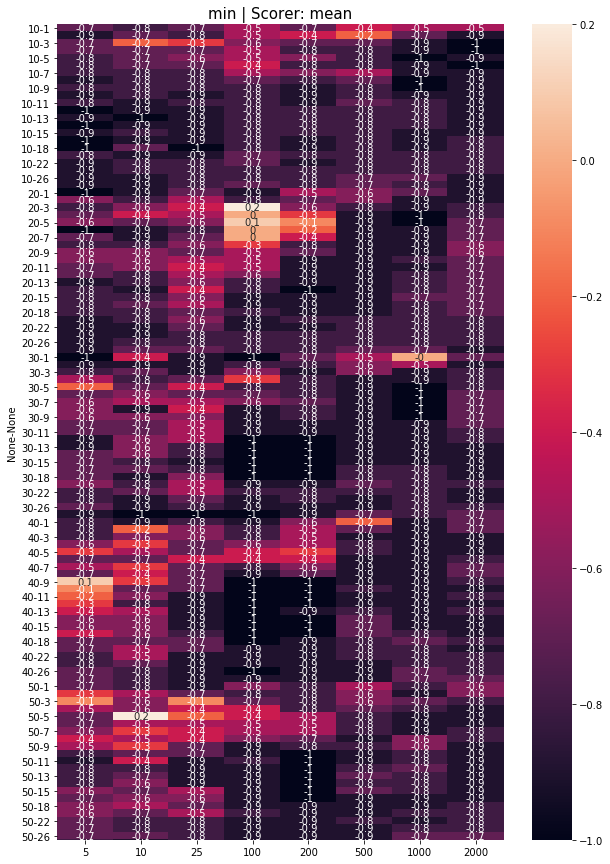

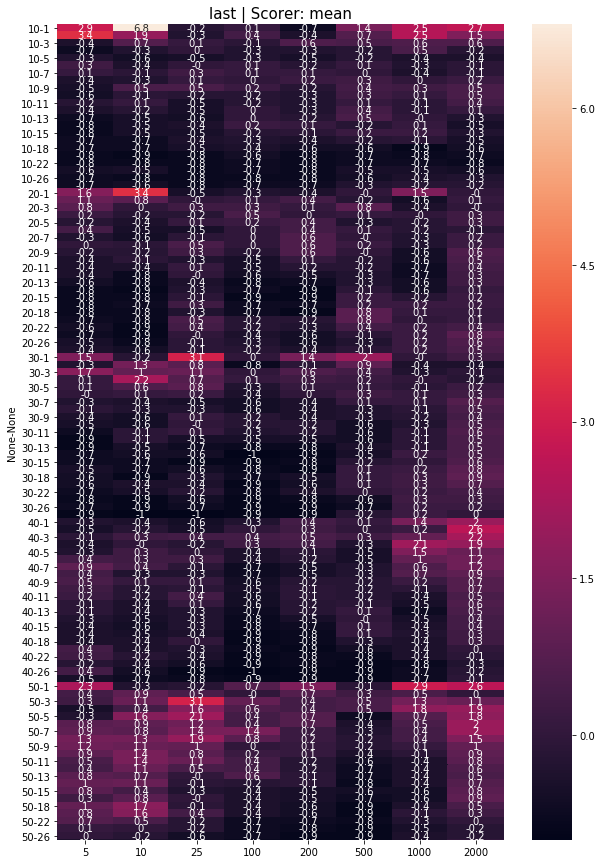

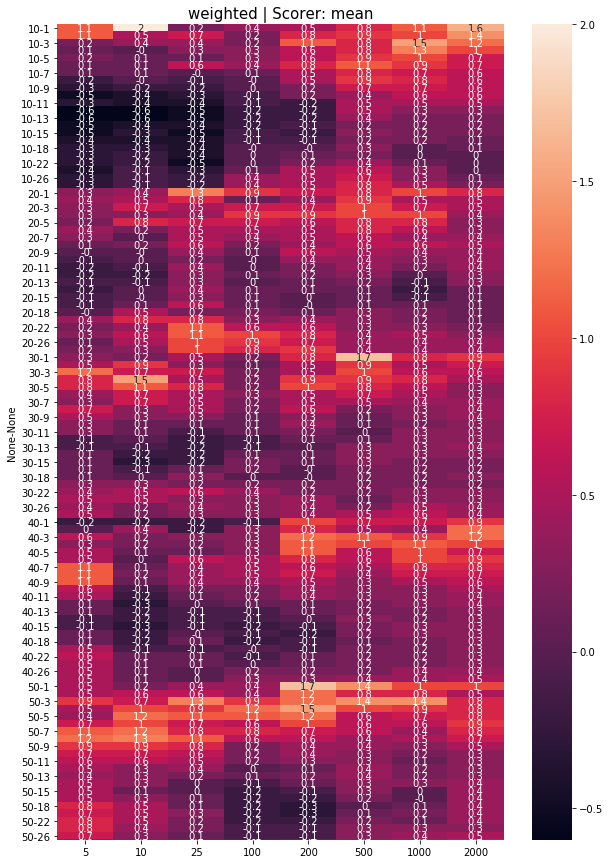

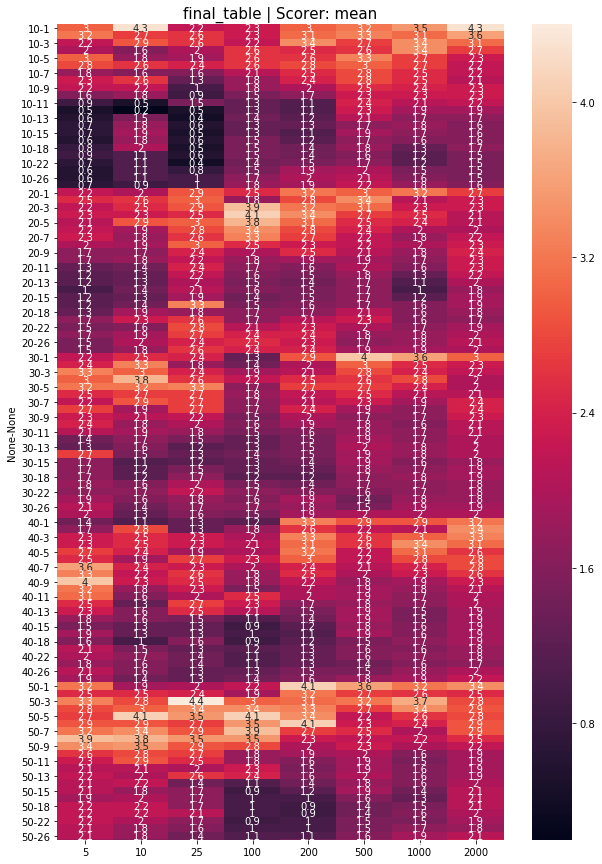

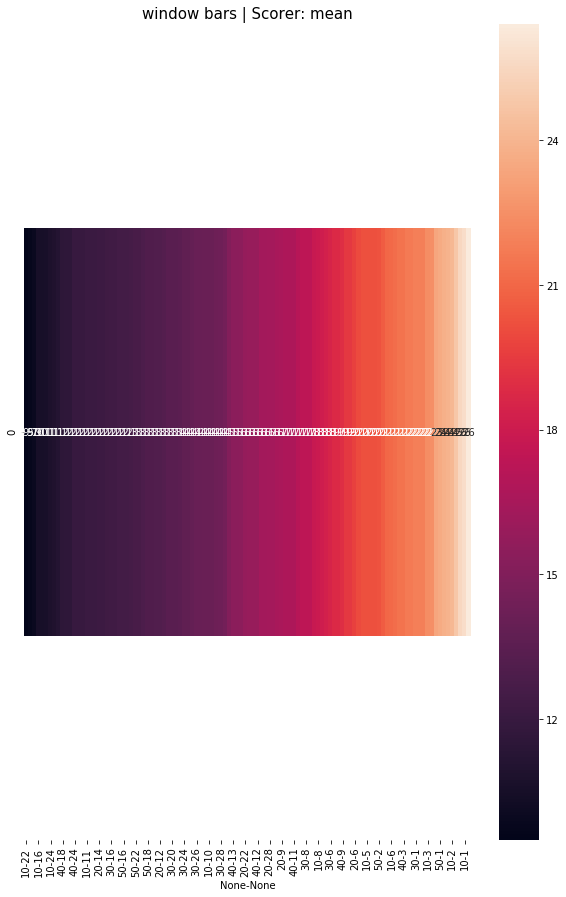

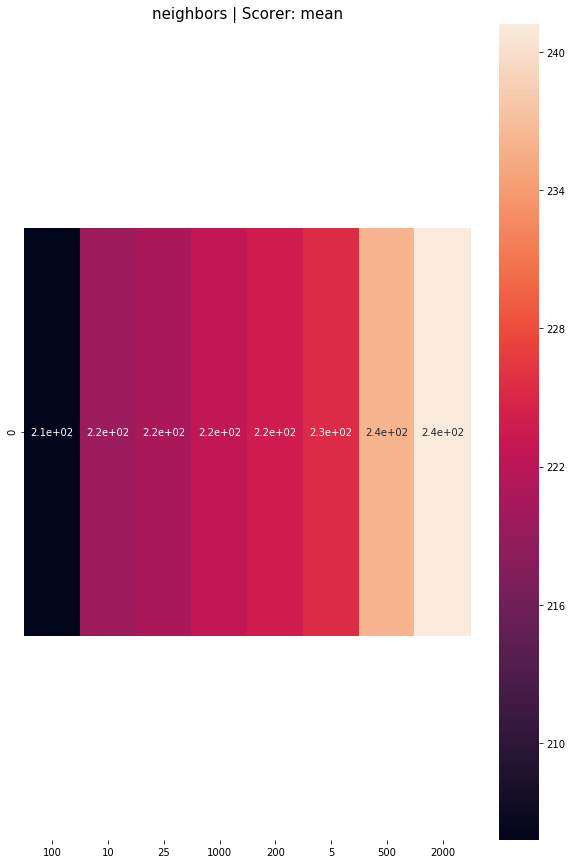

----------------------


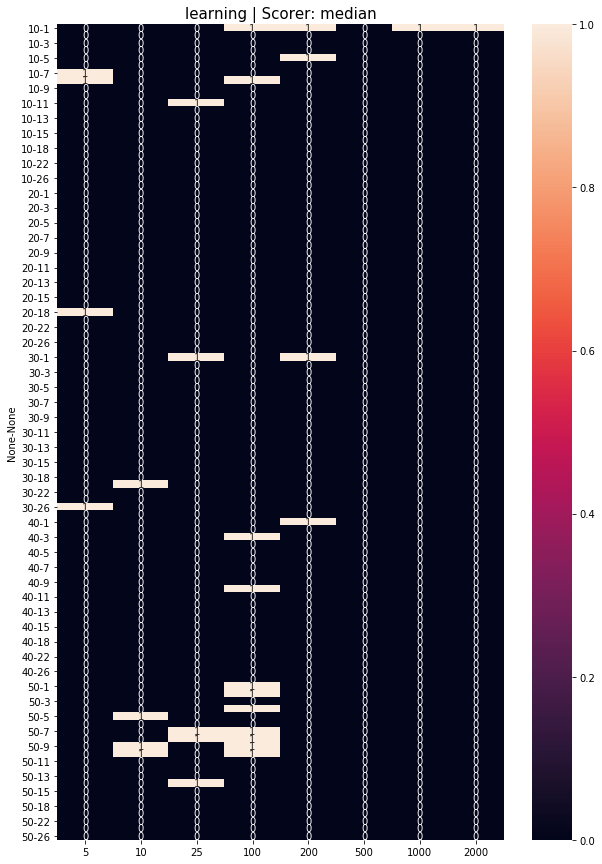

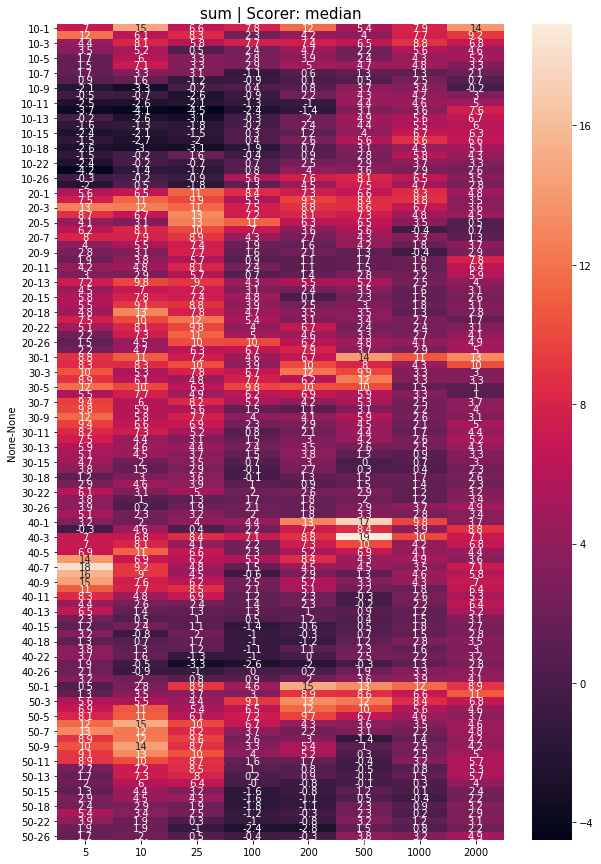

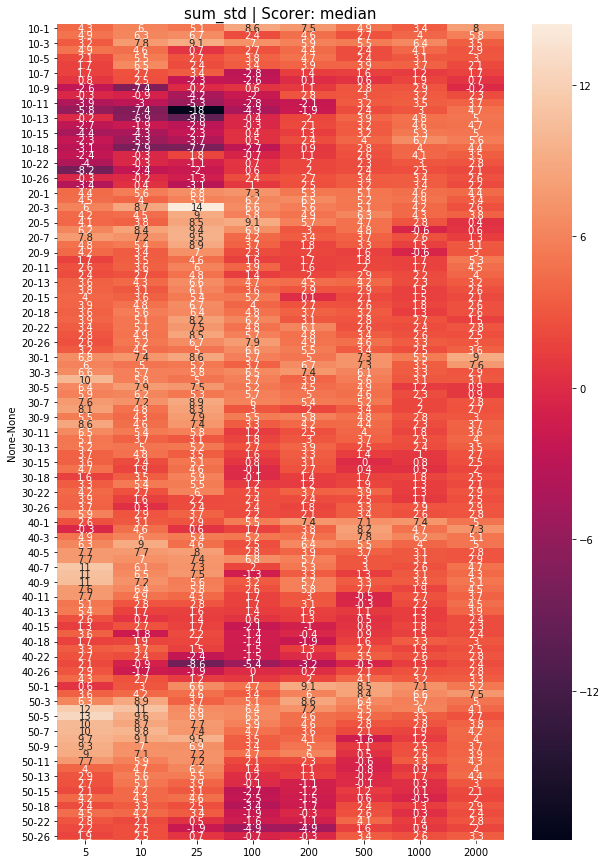

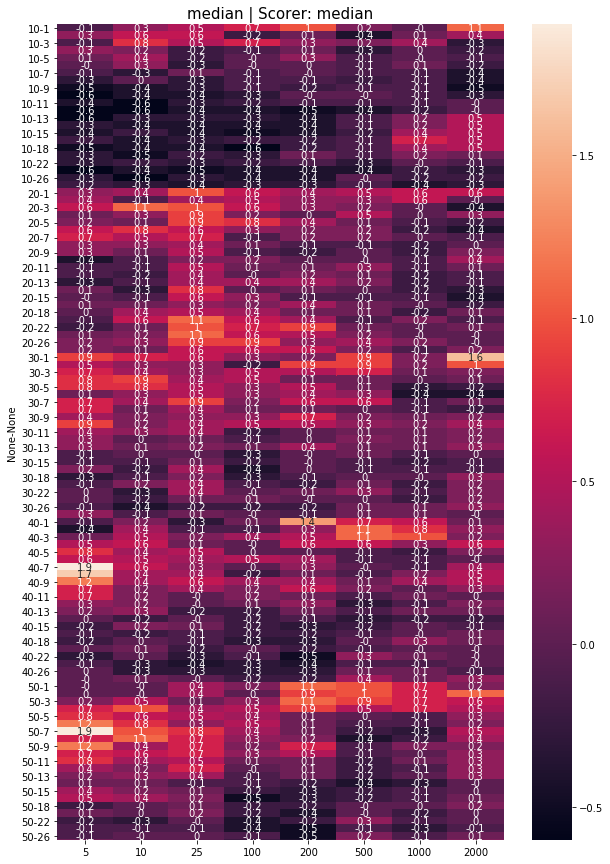

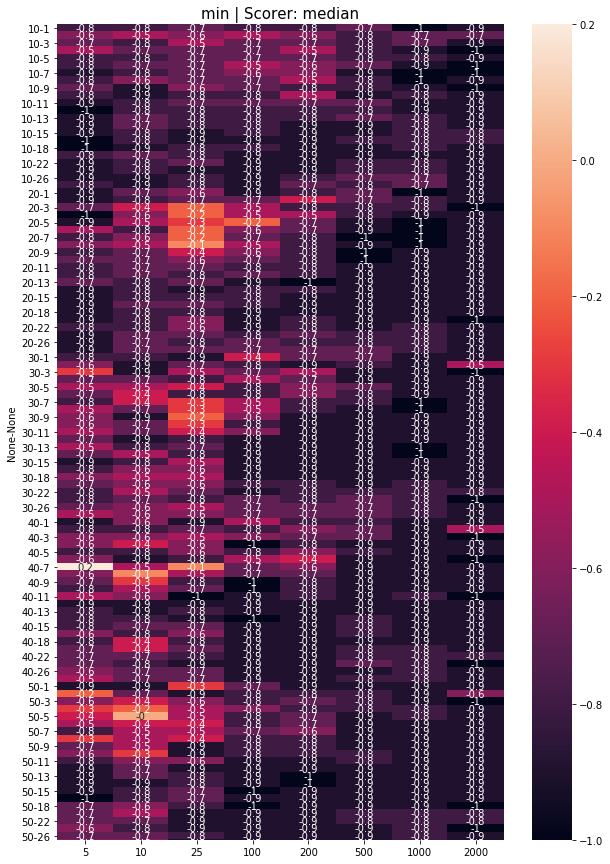

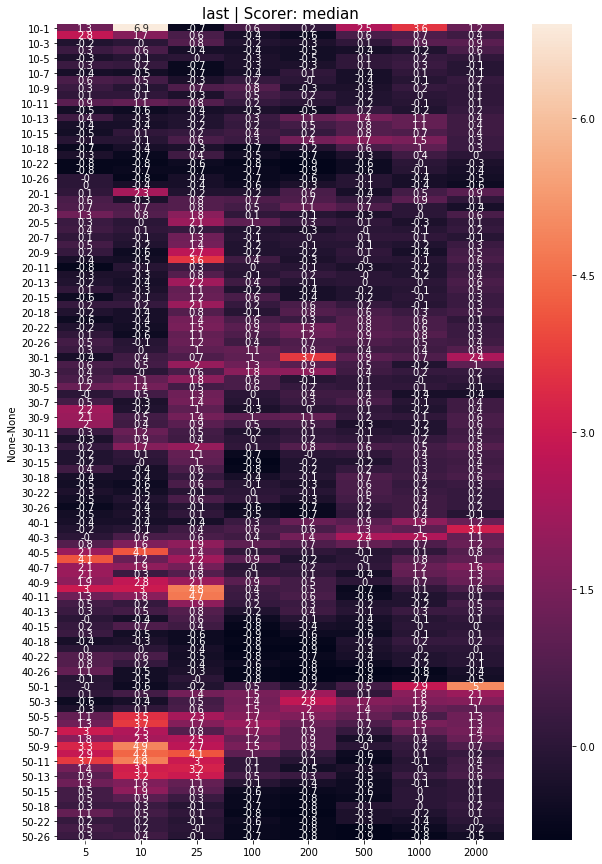

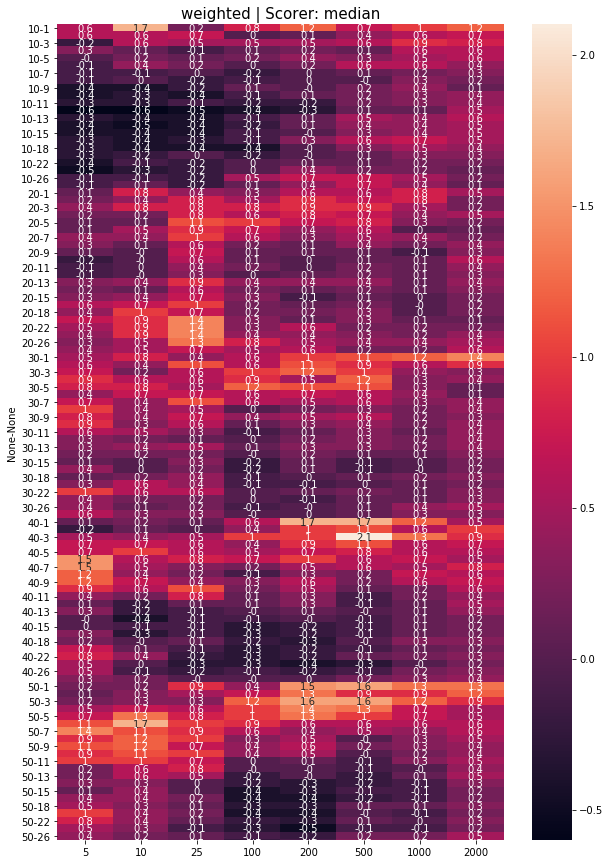

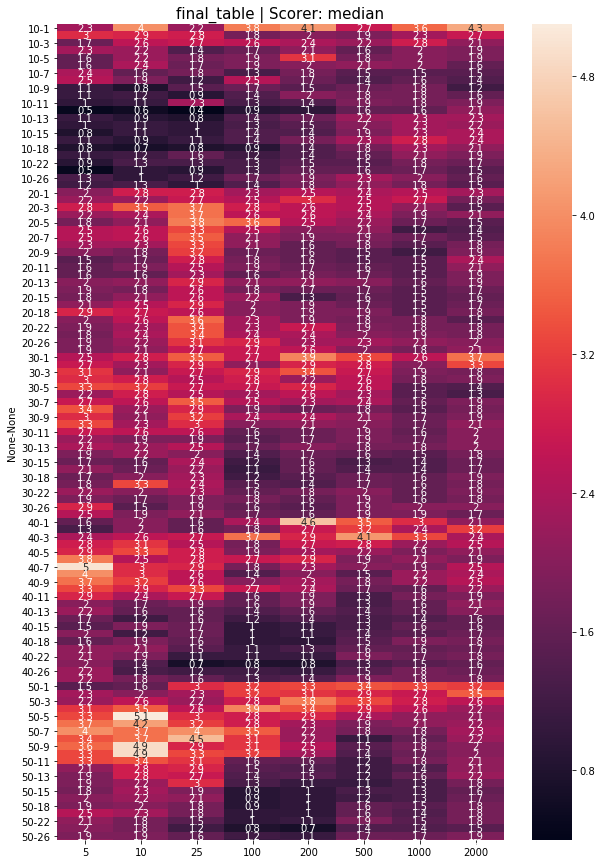

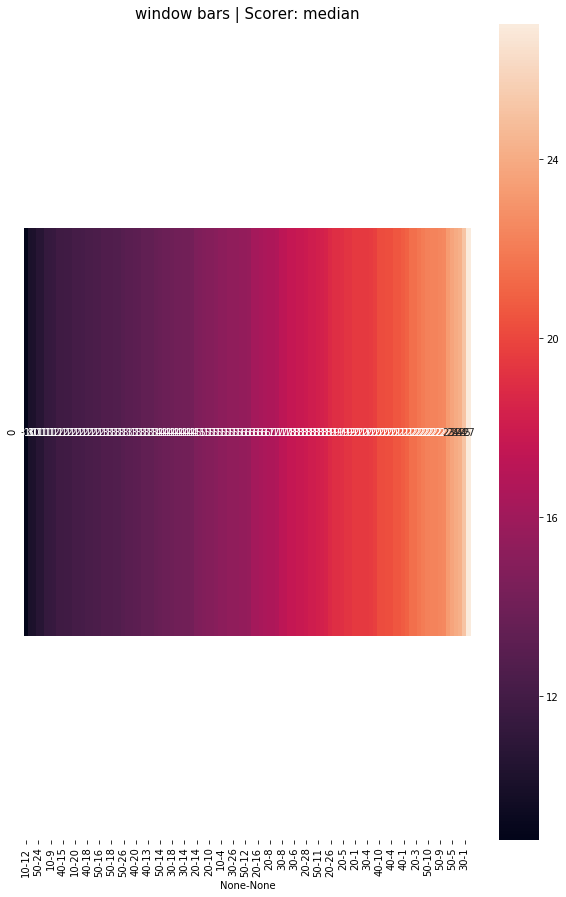

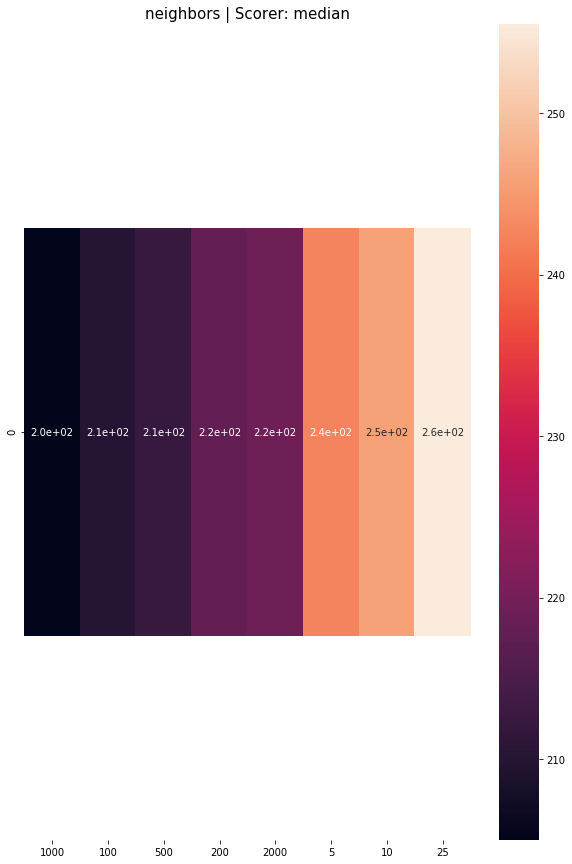

---------------


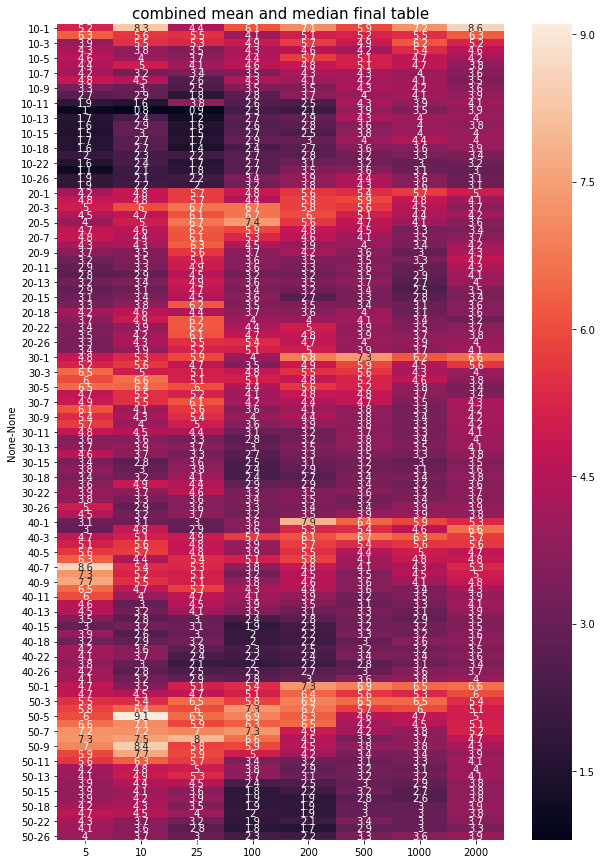

---------------


mean  median  winner
learning | sum            33.0    30.0    mean
learning | median          0.0     0.0   -----
learning | best_sum       10.0    10.0   -----
learning | best_median     1.0     1.0   -----
sum | sum               4501.9  3568.9    mean
sum | median               4.6     3.6    mean
sum | best_sum           156.7   157.6  median
sum | best_median         15.4    15.0    mean
sum_std | sum           3634.9  2853.6    mean
sum_std | median           3.8     3.3    mean
sum_std | best_sum       133.0   112.8    mean
sum_std | best_median     13.0    10.8    mean
median | sum             156.4   112.8    mean
median | median            0.1     0.1   -----
median | best_sum         14.0    14.4  median
median | best_median       1.4     1.3    mean
min | sum               -668.5  -689.7    mean
min | median              -0.8    -0.8   -----
min | best_sum             0.4    -1.2    mean
min | best_median          0.0    -0.2    mean
last | sum               -19.1   339.6  median
last | median             -0.2     0.2  median
last | best_sum           33.4    47.9  median
last | best_median         3.0     4.8  median
weighted | sum           305.7   295.9    mean
weighted | median          0.3     0.3   -----
weighted | best_sum       15.7    16.7  median
weighted | best_median     1.5     1.7  median

In [73]:
import seaborn as sns

def plot_heatmap_table(table, title, figsize=(10,15)):
    plt.figure(figsize = figsize)
    sns.heatmap(table.round(1), annot=True)
    plt.title(title, fontsize =15)
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

comparison = {}
f_tables = []
for scorer in scorers: 
    print('----------------------')
    table_comparison = {}
    final_table = []
    for name, table in tables[scorer].items():
        plot_heatmap_table(table.T, title=f'{name} | Scorer: {scorer}')
        best_scores = sorted(table.to_numpy().flatten(), reverse=True)[:10]
        table_comparison[f'{name} | sum'] = table.sum().sum()
        table_comparison[f'{name} | median'] = table.median().median()
        table_comparison[f'{name} | best_sum'] = sum(best_scores)
        table_comparison[f'{name} | best_median'] = np.median(best_scores)
        minuimum = table.min().min()
        maxuimum = table.max().max()
        normalized = (table - minuimum) / (maxuimum - minuimum)
        final_table.append(normalized)
    comparison[scorer] = table_comparison
    f_table = sum([f for f in final_table if f.sum().sum() > 0])
    f_tables.append(f_table)
    plot_heatmap_table(f_table.T, f'final_table | Scorer: {scorer}')
    plot_heatmap_table(pd.DataFrame(f_table.sum(axis=0).sort_values()).T, f'window bars | Scorer: {scorer}')
    plot_heatmap_table(pd.DataFrame(f_table.sum(axis=1).sort_values()).T, f'neighbors | Scorer: {scorer}')
    
print('---------------')
plot_heatmap_table(sum(f_tables).T, 'combined mean and median final table')
#plot_heatmap_table(f_tables[0] - f_tables[1], 'combined mean and median final table diff')
print('---------------')
final_comp = pd.DataFrame(comparison).round(1)

def winner(row):
    diff = row['mean'] - row['median']
    if diff > 0: return 'mean'
    elif diff < 0: return 'median'
    else: return '-----'
final_comp['winner'] = final_comp.apply(winner, axis=1)
final_comp

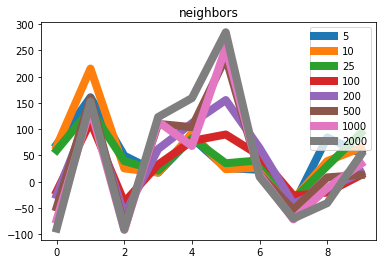

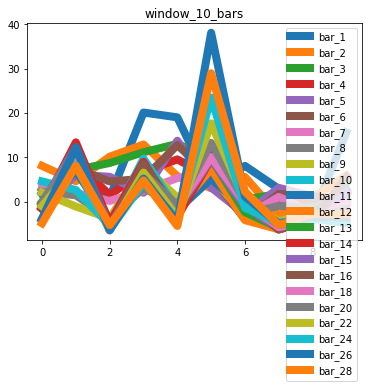

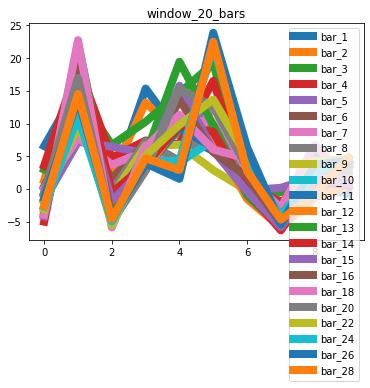

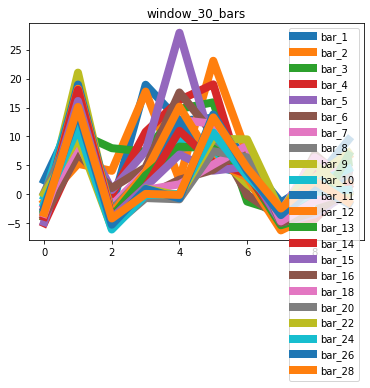

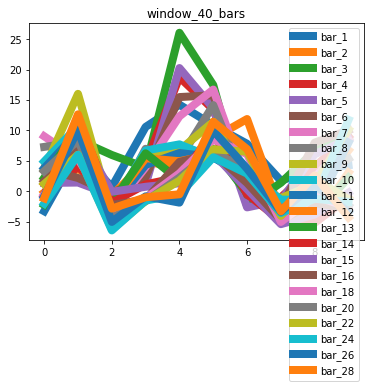

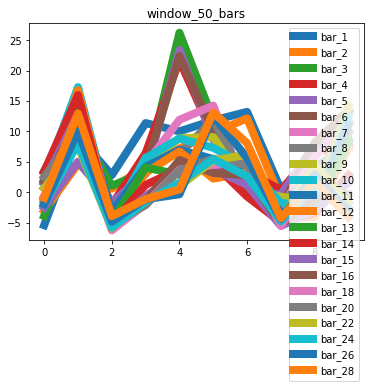

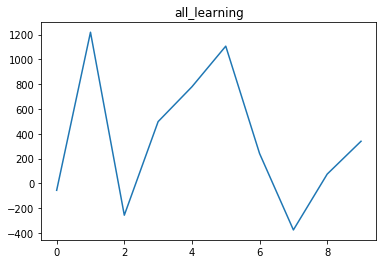

[ -56.33594184 1219.38148525 -257.21520955  498.0892783   779.31293289
 1107.14565494  240.39693001 -376.04944772   74.5806152   339.61906595]


In [74]:
the_data = pd.DataFrame(new_data['median'].to_dict())
the_data = the_data.applymap(lambda x: np.array(x))
neighbors = the_data.sum(axis=1)
for n, stats in neighbors.items():
    plt.plot(stats, label=n, lw=8)
plt.legend()
plt.title('neighbors')
plt.show()

window_bars = the_data.sum(axis=0)
windows = sorted(list(set([w[0] for w in window_bars.index.values])))
for window in windows:
    for n, stats in window_bars[window].items():
        plt.plot(stats, label=f'bar_{n}', lw=8)
    plt.legend()
    plt.title(f'window_{window}_bars')
    plt.show()

all_learning = the_data.sum().sum()
plt.plot(all_learning, label='all_learning')
plt.title('all_learning')
plt.show()
print(all_learning)

1000
[-0.2788272930976012, 1.9870438904392156, -0.6954358002931633, 0.11829070776528702, 1.0453479816464315, 3.1341077971859663, -0.23710085975592676, -0.3716027382706377, -0.8002608811219214, -0.14156816224095617]


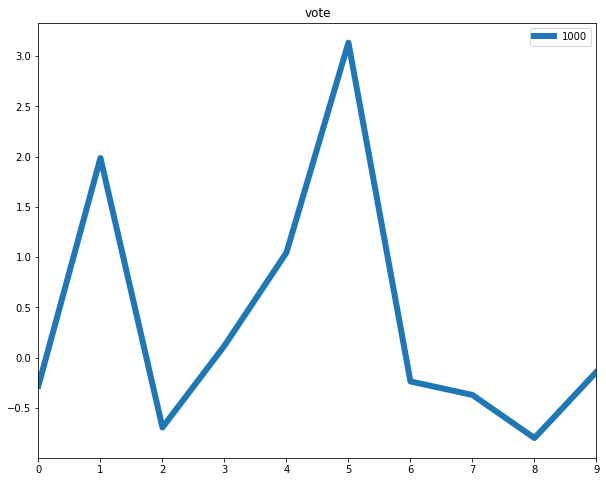

In [96]:
window = 50
bars = 10

for n, cv in means[window][bars].to_dict().items():
    if n != 1000: continue
    pd.Series(cv, name=n).plot(lw=6, figsize=(10,8), title='vote')
    print(n)
    print(cv)
plt.legend()
plt.show()

## Learning rate

In [125]:
# from sklearn.model_selection import learning_curve

# model = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
# train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, train_sizes=[0.2, 0.4, 0.6, 0.8, 1],
#                                                          cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
# valid = pd.DataFrame(valid_scores).sum(axis=1)
# train = pd.DataFrame(train_scores).sum(axis=1)
# learning_rate = pd.concat([valid, train], axis=1)
# learning_rate.columns = ['valid', 'train']
# learning_rate.plot()

## Normal test

In [18]:
# all_files = [
#              'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
#              'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
#              'NZDUSD_1h_2003-2020.csv',
#              'AUDUSD_1h_2003-2020.csv',
#              'USDCAD_1h_2003-2020.csv',
#             ]
# data = get_data(all_files)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


5e+16

fitted knn data
got data
predictions done


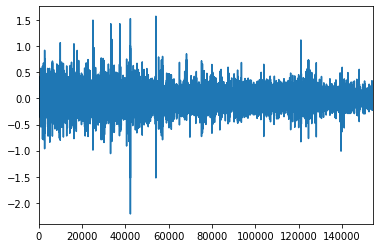

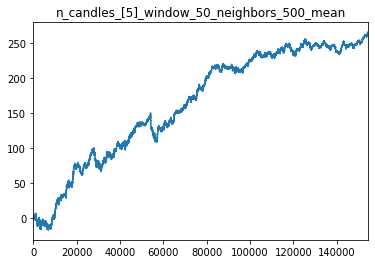

{500: ({5: 6.314776956686842}, 3781.9277490193545)}
predictions done


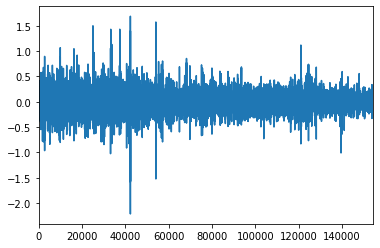

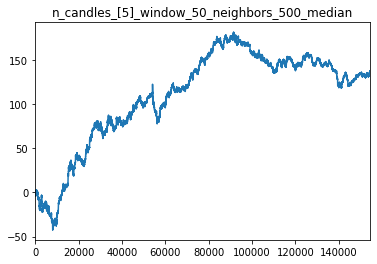

{500: ({5: 2.1632971005835997}, 1950.2264678544504)}


{500: ({5: 2.1632971005835997}, 1950.2264678544504)}

In [30]:
gpu_step_size= 300

best_risk = {}
for neighbors in [500]:
    window = 50
    n_candles = [5]
    # Train and test model
    knn_data = fit_data_for_knn(data, window=window, n_candles=n_candles)
    target =  [f"target_bars_{c}" for c in n_candles]
    features = [col for col in knn_data.columns if col not in target]
    X_train, X_test, y_train, y_test = train_test_split(knn_data[features], knn_data[target], test_size=0.3, shuffle=False)
    X_train, X_test = scale_data(X_train, X_test, df=True)
    print('got data')
 
    all_indices = knn_cuda(X_train, X_test, n_neighbors=neighbors, gpu_step_size=gpu_step_size)
    y_train_numpy = y_train.to_numpy()
    
    all_i_data = {}
    for scorer, scorer_func in [('mean',np.mean), ('median',np.median)]:       
        pred = [scorer_func(y_train_numpy[d]) for d in all_indices]
        print('predictions done')
        
        romad, i_data = cuda_trading_scorer(pred, y_test, n_candles, return_df=True)
        all_i_data[scorer] = i_data

#     ###### vote ######
#     scorer = 'vote'
#     pred_mean = [np.mean(y_train_numpy[d]) for d in all_indices]
#     pred_median = [np.median(y_train_numpy[d]) for d in all_indices]
#     romad, i_data = cuda_trading_scorer_vote(pred_mean, pred_median, y_test,
#                                             vote_type=scorer, return_df=True)
#     ##################
        
        i_data['profit'].plot()
        plt.show()

        i_data['sortino_profit'] = i_data['profit'].map(lambda x: 0 if x > 0 else x)
        sortino = i_data['run_profit'].values[-1] / i_data['sortino_profit'].std()    
        best_risk[neighbors] = (romad, sortino)

        i_data['run_profit'].plot(title=f"n_candles_{n_candles}_window_{window}_neighbors_{neighbors}_{scorer}")
        plt.show()
        print(best_risk)

best_risk

## Evaluate

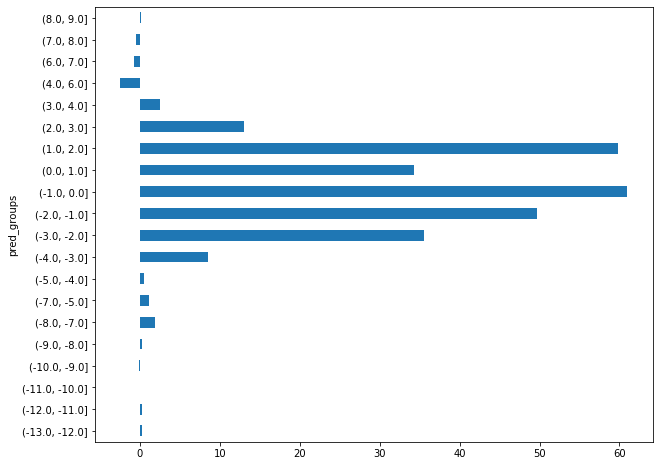

In [36]:
scorer = 'mean'
sc = 200

grouping_data = all_i_data[scorer].copy()
grouping_data['pred'] *= sc
all_i_data[scorer]['pred_groups'] = pd.cut(grouping_data['pred'], 20, precision=0)
pred_group = all_i_data[scorer].groupby('pred_groups').sum()
pred_group['profit'].plot.barh(figsize=(10,8))

{(0.36999999999999994, 2.5): 7.427983072096626}


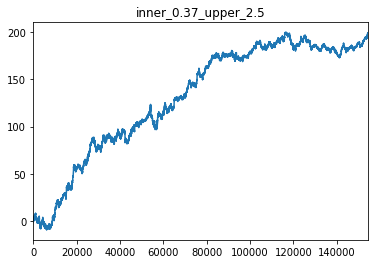

7.427983072096626


In [37]:
romad_scores = {}
for inner in np.arange(0.01,0.5,0.02):
    for upper in np.arange(2,15,0.5):
        subset = all_i_data[scorer][((all_i_data[scorer]['pred'] > -upper/sc) & (all_i_data[scorer]['pred'] < upper/sc)) &
                        ((all_i_data[scorer]['pred'] < -inner/sc) | (all_i_data[scorer]['pred'] > inner/sc))]
        run_profit = subset['profit'].cumsum()
        romad = run_profit.values[-1] / ((run_profit - run_profit.cummax()).min()*-1)
        romad_scores[(inner, upper)] = romad
best = pd.Series(romad_scores).sort_values(ascending=False).head(1).to_dict()
print(best)
inner = round(list(best.keys())[0][0],2)
upper = round(list(best.keys())[0][1],1)

subset = all_i_data[scorer][((all_i_data[scorer]['pred'] > -upper/sc) & (all_i_data[scorer]['pred'] < upper/sc)) &
                ((all_i_data[scorer]['pred'] < -inner/sc) | (all_i_data[scorer]['pred'] > inner/sc))]
subset['profit'].cumsum().plot(title=f'inner_{inner}_upper_{upper}')
plt.show()
run_profit = subset['profit'].cumsum()
romad = run_profit.values[-1] / ((run_profit - run_profit.cummax()).min()*-1)
print(romad)

In [ ]:
ax = y_train.abs().hist(bins=50)

![title](training_learning_rate_vs_n_neighbors.png)